In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#define constants
hbar = 1.055e-34 #m2kg/s
kb = 1.38e-23 #J/K

#material specific
Vuc = (6.06e-10)**3
Nbands = 6
Nq = 8

In [3]:
#file specific
Tsmp = 50; N=64

In [4]:
#import data
folder = ".\Test-VASP-sm"
dfomega = pd.read_csv(folder+"\BTE.omega",sep='\s+',header=None,skipinitialspace=True)
datomega = dfomega.values
dfv = pd.read_csv(folder+"\BTE.v",sep='\s+',header=None,skipinitialspace=True)
datv = dfv.values
dfq = pd.read_csv(folder+"\BTE.qpoints",sep='\s+',header=None,skipinitialspace=True)
datq = dfq.values
dfgiso = pd.read_csv(folder+"\BTE.w_isotopic",sep='\s+',header=None,skipinitialspace=True)
datgiso = dfgiso.values
print(datomega.shape,datv.shape,datq.shape,datgiso.shape)

(8, 6) (48, 3) (8, 6) (48, 2)


In [5]:
# import T dependent data
dfg0 = pd.read_csv(folder+f"\T{Tsmp}K"+"\BTE.w",sep='\s+',header=None,skipinitialspace=True)
datg0 = dfg0.values
dfgp = pd.read_csv(folder+f"\T{Tsmp}K"+"\BTE.w_anharmonic_plus",sep='\s+',header=None,skipinitialspace=True)
datgp = dfgp.values
dfgm = pd.read_csv(folder+f"\T{Tsmp}K"+"\BTE.w_anharmonic_minus",sep='\s+',header=None,skipinitialspace=True)
datgm = dfgm.values
print(datg0.shape,datgp.shape,datgm.shape)

(48, 2) (48, 2) (48, 2)


In [6]:
def find_tau0(g0):
    tau = 1/g0[:,1]
    tau = tau.reshape(-1,1)
    tau[np.where(tau==np.inf)] = 0
    return tau*10**(-12)
def find_vx(vv):
    return vv[:,0].reshape(-1,1)*10**3
def find_n0(w,tt):
    n0 = 1/(np.exp(hbar*w*10**12/tt/kb)-1)
    n0 = n0.T.reshape(-1,1)
    n0[np.where(n0==np.inf)] = 0
    return n0

In [7]:
# find tau0, n0, vx, f0, degeneracy
tau0 = find_tau0(datg0)
n0 = find_n0(datomega,Tsmp)
vx = find_vx(datv)

f0 = tau0*vx
degen = datq[:,2]

C:\Users\jihci\AppData\Local\Temp\ipykernel_85428\506401714.py:2: RuntimeWarning: divide by zero encountered in true_divide
  tau = 1/g0[:,1]
C:\Users\jihci\AppData\Local\Temp\ipykernel_85428\506401714.py:9: RuntimeWarning: divide by zero encountered in true_divide
  n0 = 1/(np.exp(hbar*w*10**12/tt/kb)-1)


In [8]:
# find k0
def calc_k(fin,tt,Ntot,V,n0in,w,vxin,degeneracy):
    ww = np.transpose(w).reshape(-1,1)*10**12
    #print(ww.shape)
    ss = n0in*(n0in+1)*(hbar*ww)**2*vxin*fin
    for i in range(len(ss)):
        ss[i] = ss[i]*degeneracy[i//Nbands]
    #print(ss.shape)
    k0 = sum(ss)/(kb*tt**2*Ntot*V)
    #print(k0.shape)
    return k0
k0 = calc_k(f0,Tsmp,N,Vuc,n0,datomega,vx,degen)
print(k0)

[4.18273384]


In [9]:
# find symmetry allowed pairs
def find_poss_ind_p(p0,qq):
    plus_dict = dict()
    for i in range(len(qq)):
        #plus_dict[i] = []
        for j in range(len(qq)):
            if np.all(qq[j,3:] == (qq[p0,3:] + qq[i,3:])%1):
                #plus_dict[i].append(j)
                if i in plus_dict:
                    print("multiple indices. sth wrong")
                else:
                    plus_dict[i] = j
    return plus_dict

def find_poss_ind_m(p0,qq):
    minus_dict = dict()
    for i in range(len(qq)):
        for j in range(len(qq)):
            if np.all(qq[j,3:] == (qq[p0,3:] - qq[i,3:])%1):
                if i in minus_dict:
                    print("multiple indices. sth wrong")
                else:
                    minus_dict[i] = j
    return minus_dict

def generate_poss_pairs(qq):
    dictall_p = dict()
    dictall_m = dict()
    for i in range(Nq):
        dictall_p[i] = find_poss_ind_p(i,qq)
        dictall_m[i] = find_poss_ind_m(i,qq)
    return dictall_p, dictall_m

dicts_p,dicts_m = generate_poss_pairs(datq)
print(len(dicts_p),len(dicts_m))

8 8


In [10]:
# calculate df at a specific wavevector, branch
# Nband, Nq treated as constants
def update_df_pb(fin,ppfull0,omegain,dict_pin,dict_min,tau0in):

    ppos0 = ppfull0 % Nq
    pband0 = ppfull0 // Nq
    dictp = dict_pin[ppos0]
    dictm = dict_min[ppos0]
    sump = 0
    summ = 0
    sumiso = 0

    omega0 = omegain[ppos0,pband0]

    for p1 in dictp:
        p2 = dictp[p1]
        for nband1 in range(Nbands):
            pfull1 = Nq*nband1 + p1
            for nband2 in range(Nbands):
                pfull2 = Nq*nband2 + p2
                sump += omegain[p1,nband1]/omega0*fin[pfull1] - omegain[p2,nband2]/omega0*fin[pfull2]

    for p1 in dictm:
        p2 = dictm[p1]
        for nband1 in range(Nbands):
            pfull1 = Nq*nband1 + p1
            for nband2 in range(Nbands):
                pfull2 = Nq*nband2 + p2
                summ += omegain[p1,nband1]/omega0*fin[pfull1] - omegain[p2,nband2]/omega0*fin[pfull2]

    #assume g_iso includes all omega
    for i in range(Nbands*Nq):
        sumiso += omegain[i%Nq,i//Nq]/omega0*fin[i]

    df = (1/N)*(datgp[ppfull0,1]*sump+0.5*datgm[ppfull0,1]*summ+datgiso[ppfull0,1]*sumiso)

    #return df*tau0in[ppfull0]
    return df

In [11]:
# test df at one point
df_1test = update_df_pb(f0,1,datomega,dicts_p,dicts_m,tau0)
print(df_1test)

[-2.89887264e-11]


In [13]:
# iterates - Jacobian

# iterate df once, output n*1 vector
def update_df_all_jac(fin,omegain,dict_pin,dict_min,tau0in):
    df_all = np.zeros(fin.size)
    for i in range(fin.size):
        if omegain[i%Nq,i//Nq] != 0:
            df_all[i] = update_df_pb(fin,i,omegain,dict_pin,dict_min,tau0in)
    return df_all.reshape(-1,1)

# iterate k multiple times
def iterate_k_jac(nnITER,tt,Ntot,Vin,f0in,n0in,omegain,vxin,degeneracy,dict_pin,dict_min,tau0in):
    
    fold = f0in[:]
    flist = [fold]
    dflist = [[0]*f0in.size]
    k0 = calc_k(f0in,tt,Ntot,Vin,n0in,omegain,vxin,degeneracy)
    klist = [k0]
    for _ in range(nnITER):
        df = update_df_all_jac(fold,omegain,dict_pin,dict_min,tau0in)
        #print(np.max(abs(df)))
        dflist.append(df)
        fn = f0in + df.reshape(-1,1)
        flist.append(fn)
        klist.append(calc_k(fn,tt,Ntot,Vin,n0in,omegain,vxin,degeneracy))
        fold = fn

    return flist,klist,dflist

In [14]:
def update_df_all_gs(fin,omegain,dict_pin,dict_min,tau0in):
    fold_step = np.copy(fin)
    length = fold_step.size
    df_all = np.zeros(length)
    df_all_i=0

    for i in range(length):
        if omegain[i%Nq][i//Nq] != 0:
            df_all_i = update_df_pb(fold_step,i,omegain,dict_pin,dict_min,tau0in)
            df_all[i] = df_all_i
        fold_step[i] = fold_step[i]+df_all_i

    return df_all.reshape(-1,1)

def iterate_k_gs(nnITER,tt,Ntot,Vin,f0in,n0in,omegain,vxin,degeneracy,dict_pin,dict_min,tau0in):
    fold = np.copy(f0in)
    length = len(fold)
    flist = [fold]
    dflist = [[0]*length]
    k0calc = calc_k(f0in,tt,Ntot,Vin,n0in,omegain,vxin,degeneracy)
    klist = []
    klist.append(k0calc)
    for _ in range(nnITER):
        df = update_df_all_gs(fold,omegain,dict_pin,dict_min,tau0in)
        dflist.append(df)
        fn = f0in + df
        flist.append(fn)
        klist.append(calc_k(fn,tt,Ntot,Vin,n0in,omegain,vxin,degeneracy))
        fold = fn[:]

    return flist,klist,dflist

In [15]:
def iterate_k_sor(fac,nnITER,tt,Ntot,Vin,f0in,n0in,omegain,vxin,degeneracy,dict_pin,dict_min,tau0in):
    
    fold = np.copy(f0in)
    flist = [fold]
    dflist = [[0]*fold.size]
    k0 = calc_k(f0in,tt,Ntot,Vin,n0in,omegain,vxin,degeneracy)
    klist = [k0]
    #print(klist)
    for _ in range(nnITER):
        df = update_df_all_gs(fold,omegain,dict_pin,dict_min,tau0in)*fac
        #print(np.max(abs(df)))
        dflist.append(df)
        fn = f0in + df.reshape(-1,1)
        flist.append(fn)
        klist.append(calc_k(fn,tt,Ntot,Vin,n0in,omegain,vxin,degeneracy))
        #print(klist)
        fold = fn

    return flist,klist,dflist

In [16]:
# test
fl,kl,dfl = iterate_k_jac(15,Tsmp,N,Vuc,f0,n0,datomega,vx,degen,dicts_p,dicts_m,tau0)
print(len(kl),kl)
print(f0[:3])

16 [array([4.18273384]), array([4.18388577]), array([4.18387318]), array([4.18387235]), array([4.18387232]), array([4.18387231]), array([4.18387231]), array([4.18387231]), array([4.18387231]), array([4.18387231]), array([4.18387231]), array([4.18387231]), array([4.18387231]), array([4.18387231]), array([4.18387231]), array([4.18387231])]
[[ 0.00000000e+00]
 [-1.08593525e-06]
 [ 7.50355128e-24]]


In [17]:
flgs,klgs,dflgs = iterate_k_gs(15,Tsmp,N,Vuc,f0,n0,datomega,vx,degen,dicts_p,dicts_m,tau0)
print(klgs)
print(f0[:3])

[array([4.18273384]), array([4.18388457]), array([4.18387152]), array([4.18387065]), array([4.18387061]), array([4.18387061]), array([4.18387061]), array([4.18387061]), array([4.18387061]), array([4.18387061]), array([4.18387061]), array([4.18387061]), array([4.18387061]), array([4.18387061]), array([4.18387061]), array([4.18387061])]
[[ 0.00000000e+00]
 [-1.08593525e-06]
 [ 7.50355128e-24]]


In [18]:
flsor,klsor,dflsor = iterate_k_sor(0.7,15,Tsmp,N,Vuc,f0,n0,datomega,vx,degen,dicts_p,dicts_m,tau0)
print(klsor)

[array([4.18273384]), array([4.18353935]), array([4.18353296]), array([4.18353266]), array([4.18353265]), array([4.18353265]), array([4.18353265]), array([4.18353265]), array([4.18353265]), array([4.18353265]), array([4.18353265]), array([4.18353265]), array([4.18353265]), array([4.18353265]), array([4.18353265]), array([4.18353265])]


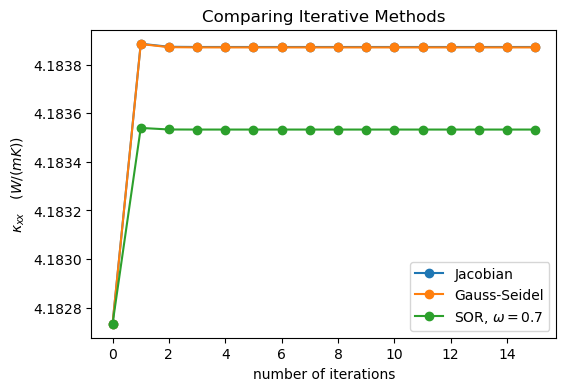

In [19]:
fig1=plt.figure(figsize=((6,4)))
plt.plot(kl,'-o',label='Jacobian')
plt.plot(klgs,'-o',label='Gauss-Seidel')
plt.plot(klsor,'-o',label=r'SOR, $\omega=0.7$')
plt.xlabel("number of iterations")
plt.ylabel(r'$\kappa_{xx}\quad(W/(mK))$')
plt.title("Comparing Iterative Methods")
plt.legend()
fig1.savefig("compare.png")

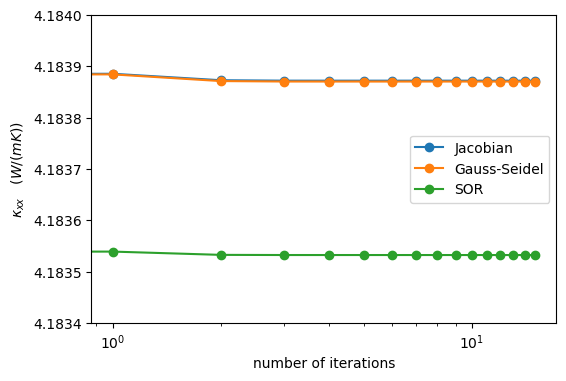

In [20]:
plt.figure(figsize=((6,4)))
plt.semilogx(kl,'-o',label='Jacobian')
plt.semilogx(klgs,'-o',label='Gauss-Seidel')
plt.semilogx(klsor,'-o',label='SOR')
plt.xlabel("number of iterations")
plt.ylabel(r'$\kappa_{xx}\quad(W/(mK))$')
plt.ylim(4.1834,4.184)
plt.legend()